# Import các thư viện cần thiết

In [ ]:
# Link drive data
# https://drive.google.com/drive/folders/1WKF9C-l-SbOKaYnxSQV1JYiuBZmI82My?usp=drive_link

In [ ]:
!pip install -U sentence-transformers FlagEmbedding

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 3.8 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.0/859.0 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.2 MB/s eta 0:00:00
  Created wheel for FlagEmbedding: filename=FlagEmbedding-1.3.4-py3-none-any.whl size=232500 sha256=d8d46c8f4ed12dc9011d6f82fa35566805615666a02ab450f283687e7a731946
  Stored in directory: /root/.cache/pip/wheels/59/8c/ba/90918a0fe0371cda2d087cffe7eb4bb4495409b6c67873a410
  Created wheel for warc3-wet-clueweb09: filename=warc3_wet_clueweb09-0.2.5-py3-none-any.whl size=18920 sha256=d1e838

In [ ]:
import json
import copy
import pandas as pd
import os
import torch
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, CrossEncoder, util

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

Using device:  cuda


In [ ]:
os.environ["WANDB_DISABLED"] = "true"

# Load Pretrained model

In [ ]:
# Model bi-encoder
pretrain_bi_encoder = SentenceTransformer('bkai-foundation-models/vietnamese-bi-encoder')
pretrain_bi_encoder.max_seq_length = 256
top_k = 64

In [ ]:
# Model cross-encoder
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["DISABLE_TQDM"] = "true"

from FlagEmbedding import FlagReranker
reranker = FlagReranker('namdp-ptit/ViRanker', use_fp16=True, show_progress=False)

tokenizer_config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/796 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

## Bi-encoder

### Xét lại ví dụ Sentence Embedding sử dụng Word2vec
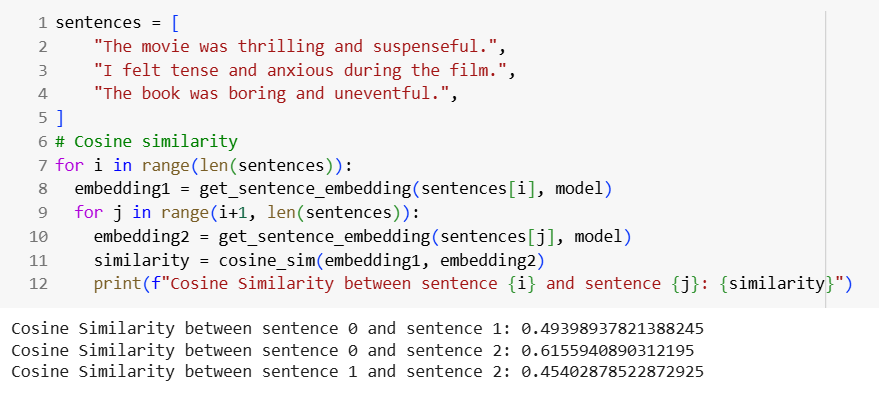

In [ ]:
# Model bi-encoder
pretrain_bi_encoder = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
pretrain_bi_encoder.max_seq_length = 256
top_k = 64

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
sentences = [
    "The movie was thrilling and suspenseful.",
    "I felt tense and anxious during the film.",
    "The book was boring and uneventful.",
]

In [ ]:
embeddings = pretrain_bi_encoder.encode(sentences)
similarities = pretrain_bi_encoder.similarity(embeddings, embeddings)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
for i in range(len(sentences)):
  for j in range(i+1, len(sentences)):
    print(f"Cosine Similarity between sentence {i} and sentence {j}: {similarities[i][j]}")

Cosine Similarity between sentence 0 and sentence 1: 0.574888288974762
Cosine Similarity between sentence 0 and sentence 2: 0.5060065984725952
Cosine Similarity between sentence 1 and sentence 2: 0.38437366485595703


### Bi-encoder với 2 tập

- Model bi-encoder tính toán vector biểu diễn cho từng phần tử, sau đó có thể tính toán độ tương đồng giữa em embedding vector
- 2 list gồm n, m văn bản => cần n+m lần embedding

In [ ]:
# Two lists of sentences
sentences1 = [
    "Bộ phim mới thật tuyệt vời",
    "Con mèo ngồi bên ngoài",
    "Một người đàn ông đang chơi đàn guitar",
]

sentences2 = [
    "Con chó chơi trong vườn",
    "Bộ phim mới thật tuyệt vời",
    "Một người phụ nữ xem TV",
]

In [ ]:
# Encode
### YOUR CODE HERE ###

### YOUR CODE HERE ###

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(3, 768)


In [ ]:
# Calculate the embedding similarities
### YOUR CODE HERE ###

### YOUR CODE HERE ###

In [ ]:
# Output the pairs with their score
### YOUR CODE HERE ###

### YOUR CODE HERE ###

Bộ phim mới thật tuyệt vời
 - Con chó chơi trong vườn       : 0.0336
 - Bộ phim mới thật tuyệt vời    : 1.0000
 - Một người phụ nữ xem TV       : 0.0729
Con mèo ngồi bên ngoài
 - Con chó chơi trong vườn       : 0.1876
 - Bộ phim mới thật tuyệt vời    : 0.1328
 - Một người phụ nữ xem TV       : 0.1142
Một người đàn ông đang chơi đàn guitar
 - Con chó chơi trong vườn       : 0.0676
 - Bộ phim mới thật tuyệt vời    : -0.1965
 - Một người phụ nữ xem TV       : 0.0440


## Cross-encoder

- Model Cross Encoder nhận vào 2 văn bản được ghép lại, tính toán độ tương đồng giữa 2 văn bản. Output là độ đo chứ không phải vector
- 2 list gồm n, m văn bản => cần n*m lần embedding

In [ ]:
# Rank a list of passages for a query
query = "Berlin có bao nhiêu bảo tàng?"

passages = [
    "Berlin có 3.520.031 cư dân đăng ký trên diện tích 891,82 km².",
    "Berlin nổi tiếng với các bảo tàng.",
    "Năm 2014, bang Berlin có 37.368 ca sinh (+6,6%), con số kỷ lục kể từ năm 1991.",
    "Vùng đô thị Berlin có khoảng 4,1 triệu người vào năm 2014, khiến nó trở thành khu vực đô thị đông dân thứ bảy trong Liên minh châu Âu.",
    "Thành phố Paris có dân số 2.165.423 người trong giới hạn hành chính của nó tính đến ngày 1 tháng 1 năm 2019.",
    "Ước tính có khoảng 300.000-420.000 người Hồi giáo cư trú tại Berlin, chiếm khoảng 8-11% dân số.",
    "Berlin được chia thành 12 quận (Bezirk).",
    "Năm 2015, tổng lực lượng lao động tại Berlin là 1,85 triệu người.",
    "Năm 2013, khoảng 600.000 người Berlin đã đăng ký tham gia hơn 2.300 câu lạc bộ thể thao và thể hình.",
    "Berlin có tổng số khoảng 135 triệu lượt khách trong một năm, đưa nó lên vị trí thứ ba trong số các điểm đến thành phố được ghé thăm nhiều nhất ở Liên minh châu Âu.",
    "Berlin có hơn 1000 bảo tàng.",
]

# ranks = pretrain_cross_encoder.rank(query, passages)
# # Print the scores
# print("Query:", query)
# for rank in ranks:
#     print(f"{rank['score']:.2f}\t{passages[rank['corpus_id']]}")

print("Query:", query)
for ans in passages:
    score = reranker.compute_score([query, ans], normalize=True)[0]
    print(f"{score:.2f}\t{ans}")

Query: Berlin có bao nhiêu bảo tàng?


Chunks: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


0.01	Berlin có 3.520.031 cư dân đăng ký trên diện tích 891,82 km².


Chunks: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


0.86	Berlin nổi tiếng với các bảo tàng.


Chunks: 100%|██████████| 1/1 [00:00<00:00, 22.99it/s]


0.00	Năm 2014, bang Berlin có 37.368 ca sinh (+6,6%), con số kỷ lục kể từ năm 1991.


Chunks: 100%|██████████| 1/1 [00:00<00:00, 24.99it/s]


0.00	Vùng đô thị Berlin có khoảng 4,1 triệu người vào năm 2014, khiến nó trở thành khu vực đô thị đông dân thứ bảy trong Liên minh châu Âu.


Chunks: 100%|██████████| 1/1 [00:00<00:00, 25.33it/s]


0.00	Thành phố Paris có dân số 2.165.423 người trong giới hạn hành chính của nó tính đến ngày 1 tháng 1 năm 2019.


Chunks: 100%|██████████| 1/1 [00:00<00:00, 24.43it/s]


0.00	Ước tính có khoảng 300.000-420.000 người Hồi giáo cư trú tại Berlin, chiếm khoảng 8-11% dân số.


Chunks: 100%|██████████| 1/1 [00:00<00:00, 24.66it/s]


0.01	Berlin được chia thành 12 quận (Bezirk).


Chunks: 100%|██████████| 1/1 [00:00<00:00, 25.14it/s]


0.00	Năm 2015, tổng lực lượng lao động tại Berlin là 1,85 triệu người.


Chunks: 100%|██████████| 1/1 [00:00<00:00, 24.53it/s]


0.00	Năm 2013, khoảng 600.000 người Berlin đã đăng ký tham gia hơn 2.300 câu lạc bộ thể thao và thể hình.


Chunks: 100%|██████████| 1/1 [00:00<00:00, 24.73it/s]


0.00	Berlin có tổng số khoảng 135 triệu lượt khách trong một năm, đưa nó lên vị trí thứ ba trong số các điểm đến thành phố được ghé thăm nhiều nhất ở Liên minh châu Âu.


Chunks: 100%|██████████| 1/1 [00:00<00:00, 25.02it/s]

1.00	Berlin có hơn 1000 bảo tàng.


## Nhận xét

- Các mô hình Cross Encoder thường có độ chính xác cao hơn các mô hình bi-encoder (do xét quan hệ giữa 2 văn bản ghi ghép lại), tuy nhiên chúng lại có tốc độ tính toán chậm hơn
  - Model bi-encoder sẽ mất n + 1 lần encode ( n là sô văn bản), còn cross-encoder sẽ mất 2n lần encode(do encode query n lần)
- Việc kết hợp 1 model bi-encoder(Retrieve) với 1 model Cross Encoder(Re-Rank) giúp ta tối ưu tốc độ mà vấn giữ được độ chính xác cao.
=> Model bi-encoder lọc ra 1 lượng văn bản gần với query, sau đó re-rank bằng cross-encoder 1 lần nữa

# Bài toán Truy xuất thông tin văn bản pháp luật

## Load Dataset

In [ ]:
dataset_json_path = "/kaggle/input/clean-legal-corpus/clean_legal_corpus.json"
with open(dataset_json_path, "r") as f:
  dataset_json = json.load(f)

In [ ]:
print(len(dataset_json))

3263


In [ ]:
dataset_json[0]["articles"][0]

{'article_id': '1',
 'title': 'Điều 1. Phạm vi áp dụng',
 'text': 'Thông tư này hướng dẫn tuần tra, canh gác bảo vệ đê Điều trong mùa lũ đối với các tuyến đê sông được phân loại, phân cấp theo quy định tại Điều 4 của Luật Đê Điều.'}

In [ ]:
passages = []
article_ids = []
law_ids = []
for law in dataset_json:
    law_id = law["law_id"]
    for article in law["articles"]:
        text = f"{article['title']}: {article['text']}"
        passages.append(text)
        article_ids.append(article["article_id"])
        law_ids.append(law_id)

In [ ]:
passages[0]

'Điều 1. Phạm vi áp dụng: Thông tư này hướng dẫn tuần tra, canh gác bảo vệ đê Điều trong mùa lũ đối với các tuyến đê sông được phân loại, phân cấp theo quy định tại Điều 4 của Luật Đê Điều.'

## Test Dataset

In [ ]:
test_qa_path = "/kaggle/input/test-qa/test_question_answer_final.json"
with open(test_qa_path, "r") as f:
    test_qa_json = json.load(f)

In [ ]:
print(type(test_qa_json))

<class 'dict'>


In [ ]:
test_questions = []
test_law_ids = []
test_article_ids = []
for item in test_qa_json["items"]:
    test_questions.append(item["question"])
    test_law_ids.append(item["relevant_articles"][0]["law_id"])
    test_article_ids.append(str(item["relevant_articles"][0]["article_id"]))

In [ ]:
print(f"Question: {test_questions[0]}")
print(f"Law_id: {test_law_ids[0]}")
print(f"Article_id: {test_article_ids[0]}")

Question: Đới khoáng hóa là gì?
Law_id: 42/2016/tt-btnmt
Article_id: 3


## Hàm xử lý

In [ ]:
def embed_copus(model):
    corpus_embeddings = model.encode(passages, convert_to_tensor=True, show_progress_bar=True)
    return corpus_embeddings

In [ ]:
def search(bi_encoder, cross_encoder, corpus_embeddings, query):
# def search(bi_encoder, reranker, corpus_embeddings, query):
    query_embedding = bi_encoder.encode(query, convert_to_tensor=True, show_progress_bar=False)
    hits = util.semantic_search(query_embedding, corpus_embeddings, top_k=top_k)
    hits = hits[0]
    # Chuẩn bị đầu vào cho Cross-Encoder
    cross_inp = [[query, passages[hit['corpus_id']]] for hit in hits]
    # cross_scores = cross_encoder.predict(cross_inp, show_progress_bar=False)
    cross_scores = reranker.compute_score(cross_inp, normalize=True)

    # Gán điểm số của Cross-Encoder vào kết quả
    for i, score in enumerate(cross_scores):
        hits[i]['cross-score'] = score

    # Sắp xếp lại kết quả theo điểm số của Cross-Encoder
    hits = sorted(hits, key=lambda x: x['cross-score'], reverse=True)

    # Hiển thị kết quả
    # print("\n **Top 3 results:**")
    # for hit in hits[:3]:
    #     idx = hit['corpus_id']
    #     print(f"{hit['cross-score']:.3f} - {passages[idx]} - {article_ids[idx]} - {law_ids[idx]}")
    idx = hits[0]['corpus_id']
    return article_ids[idx], law_ids[idx]

In [ ]:
def predict(bi_encoder, cross_encoder, corpus_embeddings):
    pred_law_ids = []
    pred_article_ids = []
    for question in tqdm(test_questions, desc="Processing: "):
        article_id, law_id = search(bi_encoder, cross_encoder, corpus_embeddings, question)
        # article_id, law_id = search(pretrain_bi_encoder, reranker ,pretrain_corpus_embeddings, question)
        pred_law_ids.append(law_id)
        pred_article_ids.append(article_id)
    return pred_law_ids, pred_article_ids

In [ ]:
def eval_accuracy(pred_law_ids, pred_article_ids):
    correct_count = sum(
        1 for true_law, true_article, pred_law, pred_article in zip(test_law_ids, test_article_ids, pred_law_ids, pred_article_ids)
        if str(true_law).strip().lower() == str(pred_law).strip().lower()
        and str(true_article).strip().lower() == str(pred_article).strip().lower()
    )

    accuracy = correct_count / len(test_law_ids)
    return accuracy

## Sử dụng pretrained model

In [ ]:
query = "Thời gian viên chức nghỉ thai sản có đánh giá chất lượng không?"
sentences = [
    "1. Việc đánh giá, xếp loại chất lượng cán bộ, công chức, viên chức được thực hiện theo từng năm công tác.\nĐối với cán bộ, công chức, viên chức chuyển công tác thì cơ quan, tổ chức, đơn vị mới có trách nhiệm đánh giá, xếp loại chất lượng. Trường hợp có thời gian công tác ở cơ quan, tổ chức, đơn vị cũ từ 06 tháng trở lên thì phải kết hợp với ý kiến nhận xét của cơ quan, tổ chức, đơn vị cũ, trừ trường hợp không còn cơ quan, tổ chức, đơn vị cũ.\n2. Thời điểm đánh giá, xếp loại chất lượng cán bộ, công chức, viên chức được tiến hành trước ngày 15 tháng 12 hàng năm, trước khi thực hiện việc đánh giá, xếp loại chất lượng đảng viên và tổng kết công tác bình xét thi đua, khen thưởng hàng năm của cơ quan, tổ chức, đơn vị.\nĐối với đơn vị sự nghiệp công lập hoạt động trong lĩnh vực giáo dục, đào tạo và một số lĩnh vực khác có thời điểm kết thúc năm công tác trước tháng 12 hàng năm thì người đứng đầu đơn vị sự nghiệp công lập quyết định thời điểm đánh giá, xếp loại chất lượng viên chức.\n3. Tại thời điểm đánh giá, xếp loại chất lượng, trường hợp vắng mặt có lý do chính đáng hoặc nghỉ ốm, nghỉ chế độ thai sản theo quy định của pháp luật, cán bộ, công chức, viên chức có trách nhiệm làm báo cáo tự đánh giá, nhận mức xếp loại kết quả công tác theo chức trách, nhiệm vụ được giao, gửi cơ quan, tổ chức, đơn vị đang công tác để thực hiện việc đánh giá, xếp loại chất lượng theo quy định tại Nghị định này.\nCăn cứ khoản 1 và khoản 2 Điều này và đặc thù của cơ quan, tổ chức, đơn vị, tập thể lãnh đạo cơ quan, tổ chức, đơn vị thống nhất với cấp ủy cùng cấp về việc kết hợp tổ chức cuộc họp đánh giá, xếp loại trong cơ quan, tổ chức, đơn vị mình, bảo đảm nghiêm túc, hiệu quả, tránh hình thức, lãng phí.",
    "1. Căn cứ điều kiện cụ thể của cơ quan, tổ chức, đơn vị, người đứng đầu cơ quan, tổ chức, đơn vị quản lý công chức, viên chức ban hành hoặc giao người đứng đầu cơ quan, tổ chức, đơn vị sử dụng công chức, viên chức ban hành Quy chế đánh giá phù hợp với đặc thù của cơ quan, tổ chức, đơn vị mình.\nNội dung Quy chế phải xác định rõ sản phẩm cụ thể gắn với từng vị trí việc làm, tiêu chí đánh giá chất lượng, hiệu quả, thời điểm đánh giá theo quý, tháng hoặc tuần (nếu có); căn cứ để xác định tỉ lệ % mức độ hoàn thành công việc; các tiêu chí thành phần để đánh giá và xếp loại chất lượng cán bộ, công chức, viên chức, trong đó có tính đến tỷ lệ khối lượng công việc của cán bộ, công chức, viên chức đã thực hiện so với khối lượng công việc chung của cơ quan, tổ chức, đơn vị; khuyến khích áp dụng công nghệ thông tin để thực hiện đánh giá, xếp loại chất lượng cán bộ, công chức, viên chức, bảo đảm phù hợp với các quy định tại Nghị định này.\nViệc đánh giá, xếp loại chất lượng đối với người làm việc trong tổ chức cơ yếu thực hiện theo quy định của pháp luật về cơ yếu và không trái với nguyên tắc đánh giá, xếp loại cán bộ của cấp có thẩm quyền.\n2. Kết quả đánh giá của các năm trước năm 2020 được tính liên tục để áp dụng các quy định có liên quan đối với cán bộ, công chức, viên chức.\n3. Người đứng đầu cơ quan quản lý cán bộ, công chức, viên chức chịu trách nhiệm tổ chức thực hiện việc đánh giá, xếp loại chất lượng đối với cán bộ, công chức, viên chức hàng năm theo quy định tại Nghị định này; chịu trách nhiệm về số lượng, chất lượng công tác đánh giá, xếp loại chất lượng và gửi báo cáo kết quả đánh giá, xếp loại chất lượng cán bộ, công chức, viên chức thuộc thẩm quyền quản lý về Bộ Nội vụ để tổng hợp trước ngày 01 tháng 3 hàng năm.\n4. Bộ Nội vụ có trách nhiệm theo dõi, kiểm tra, tổng hợp, báo cáo Chính phủ, Thủ tướng Chính phủ kết quả đánh giá, xếp loại chất lượng cán bộ, công chức, viên chức hàng năm của các bộ, ngành, địa phương và công khai kết quả tổng hợp đánh giá, xếp loại chất lượng cán bộ, công chức, viên chức hàng năm.",
    "Nghị định này quy định về công khai kết quả kiểm toán, kết quả thực hiện kết luận, kiến nghị kiểm toán của Kiểm toán Nhà nước (sau đây gọi tắt là công khai kết quả kiểm toán) và trách nhiệm của Kiểm toán Nhà nước; các cơ quan, đơn vị, tổ chức đã được kiểm toán; các Bộ, ngành, cơ quan, đơn vị, tổ chức và cá nhân có liên quan trong việc tổ chức công khai kết quả kiểm toán.",
]
# Calculate embeddings by calling model.encode()
embeddings1 = pretrain_bi_encoder.encode(query)
embeddings2 = pretrain_bi_encoder.encode(sentences)
print(embeddings1.shape)

# Output the pairs with their score
similarities = pretrain_bi_encoder.similarity(embeddings1, embeddings2)
print(query)
for idx_j, sentence in enumerate(sentences):
    print(f" - {sentence: <30}: {similarities[0][idx_j]:.4f}")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(768,)
Thời gian viên chức nghỉ thai sản có đánh giá chất lượng không?
 - 1. Việc đánh giá, xếp loại chất lượng cán bộ, công chức, viên chức được thực hiện theo từng năm công tác.
Đối với cán bộ, công chức, viên chức chuyển công tác thì cơ quan, tổ chức, đơn vị mới có trách nhiệm đánh giá, xếp loại chất lượng. Trường hợp có thời gian công tác ở cơ quan, tổ chức, đơn vị cũ từ 06 tháng trở lên thì phải kết hợp với ý kiến nhận xét của cơ quan, tổ chức, đơn vị cũ, trừ trường hợp không còn cơ quan, tổ chức, đơn vị cũ.
2. Thời điểm đánh giá, xếp loại chất lượng cán bộ, công chức, viên chức được tiến hành trước ngày 15 tháng 12 hàng năm, trước khi thực hiện việc đánh giá, xếp loại chất lượng đảng viên và tổng kết công tác bình xét thi đua, khen thưởng hàng năm của cơ quan, tổ chức, đơn vị.
Đối với đơn vị sự nghiệp công lập hoạt động trong lĩnh vực giáo dục, đào tạo và một số lĩnh vực khác có thời điểm kết thúc năm công tác trước tháng 12 hàng năm thì người đứng đầu đơn vị sự nghiệp công lập q

In [ ]:
pretrain_corpus_embeddings = embed_copus(pretrain_bi_encoder)

Batches:   0%|          | 0/1901 [00:00<?, ?it/s]

In [ ]:
query = "Nguyên tắc xác định tổ chức, cá nhân làm môi trường bị ô nhiễm, suy thoái theo quy định của pháp luật"
# search(pretrain_bi_encoder, pretrain_cross_encoder,pretrain_corpus_embeddings, query)
search(pretrain_bi_encoder, reranker,pretrain_corpus_embeddings, query)

Chunks: 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]


('13', '03/2015/nđ-cp')

In [ ]:
# pretrain_pred_law_ids, pretrain_pred_article_ids = predict(pretrain_bi_encoder, pretrain_cross_encoder, pretrain_corpus_embeddings)
pretrain_pred_law_ids, pretrain_pred_article_ids = predict(pretrain_bi_encoder, reranker, pretrain_corpus_embeddings)
pretrain_accuracy = eval_accuracy(pretrain_pred_law_ids, pretrain_pred_article_ids)

Processing: 100%|██████████| 511/511 [10:43<00:00,  1.26s/it]

Accuracy: 66.54%


In [ ]:
print(f"Accuracy: {pretrain_accuracy:.2%}")

Accuracy: 66.54%


In [ ]:
print(test_law_ids[:7])
print(pretrain_pred_law_ids[:7])

['42/2016/tt-btnmt', '55/2020/nđ-cp', '90/2020/nđ-cp', '11/2021/nđ-cp', '19/2020/nđ-cp', '03/2015/nđ-cp', '16/2020/tt-bqp']
['42/2016/tt-btnmt', '55/2020/nđ-cp', '90/2020/nđ-cp', '11/2021/nđ-cp', '19/2020/nđ-cp', '03/2015/nđ-cp', '99/2017/tt-bqp']


In [ ]:
print(test_article_ids[:7])
print(pretrain_pred_article_ids[:7])

['3', '4', '20', '24', '26', '13', '4']
['3', '4', '2', '24', '26', '13', '37']


## Fine-tune model

In [ ]:
from sentence_transformers import InputExample, SentenceTransformer, losses, datasets
from torch.utils.data import DataLoader

### Fine-tune Bi-encoder model

In [ ]:
finetune_bi_dataset = "/kaggle/input/finetune-bi-data/finetune_bienc_data.csv"
bi_df = pd.read_csv(finetune_bi_dataset)
bi_df = bi_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
bi_df.head()

,question,answer,label
0,"Mức phạt khi dừng, đỗ xe ô tô trên đường cao t...",Ban hành kèm theo Thông tư liên tịch này các m...,0
1,Máy móc như thế nào được hiểu là máy móc đã qu...,"1. Các loại thuế, khoản thu khác thuộc ngân sá...",0
2,Phiếu đồng ý tham gia nghiên cứu y sinh học li...,"Trong Thông tư này, các từ ngữ dưới đây được h...",1
3,Xây dựng trang trại nuôi lợn quy mô nhỏ cách c...,"Chủ trì, phối hợp với Bộ Tài chính, Bộ Giao th...",0
4,Mức chi quản lý chương trình đề án khuyến công...,1. Chi hỗ trợ thành lập doanh nghiệp sản xuất ...,1


In [ ]:
print(bi_df.isnull().sum())

question     0
answer      67
label        0
dtype: int64


In [ ]:
bi_df = bi_df.dropna(subset=['answer'])

In [ ]:
len(bi_df[bi_df["label"] == 1]), len(bi_df[bi_df["label"] == 0])

(8658, 17314)

In [ ]:
# Đếm số lượng mỗi nhãn
num_label_1 = len(bi_df[bi_df["label"] == 1])  # Số lượng nhãn 1
num_label_0 = len(bi_df[bi_df["label"] == 0])  # Số lượng nhãn 0

# Lấy mẫu ngẫu nhiên từ nhãn 0 sao cho bằng số nhãn 1
bi_df_0 = bi_df[bi_df["label"] == 0].sample(n=num_label_1, random_state=42)

# Lấy tất cả dữ liệu nhãn 1
bi_df_1 = bi_df[bi_df["label"] == 1]

# Gộp hai tập dữ liệu lại
balanced_bi_df = pd.concat([bi_df_0, bi_df_1]).sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
len(balanced_bi_df[balanced_bi_df["label"] == 1]), len(balanced_bi_df[balanced_bi_df["label"] == 0])

(8658, 8658)

In [ ]:
bi_train_samples = []
for _, row in balanced_bi_df.iterrows():
    bi_train_samples.append(InputExample(texts=[row["question"], row["answer"]], label=row["label"]))

In [ ]:
print(bi_train_samples[0])

<InputExample> label: 0, texts: Thời hạn sử dụng giấy đăng ký xe của cơ quan đại diện ngoại giao; Chế độ tử tuất đối với thân nhân của người lao động chết mà trước đó có thời gian đóng bảo hiểm xã hội tự nguyện theo Điều 71 của Luật Bảo hiểm xã hội được quy định như sau:
1. Thời gian tính hưởng chế độ tử tuất là tổng thời gian đã đóng bảo hiểm xã hội tự nguyện và bảo hiểm xã hội bắt buộc.
2. Người lo mai táng được nhận trợ cấp mai táng bằng 10 lần mức lương cơ sở đối với người lao động chết thuộc một trong các trường hợp sau:
a) Người lao động có thời gian đóng bảo hiểm xã hội bắt buộc từ đủ 12 tháng trở lên;
b) Người lao động có tổng thời gian đóng bảo hiểm xã hội bắt buộc và bảo hiểm xã hội tự nguyện từ đủ 60 tháng trở lên;
c) Người lao động chết do tai nạn lao động, bệnh nghề nghiệp hoặc chết trong thời gian điều trị do tai nạn lao động, bệnh nghề nghiệp;
d) Người đang hưởng lương hưu; hưởng trợ cấp tai nạn lao động, bệnh nghề nghiệp hằng tháng đã nghỉ việc.
3. Người quy định tại Kh

In [ ]:
bi_train_dataloader = DataLoader(bi_train_samples, shuffle=True, batch_size=16)

# Sử dụng MultipleNegativesRankingLoss để huấn luyện
bi_train_loss = losses.MultipleNegativesRankingLoss(pretrain_bi_encoder)

In [ ]:
# Sao chép model gốc để fine-tune mà không ảnh hưởng đến bi_encoder
finetuned_bi_encoder = copy.deepcopy(pretrain_bi_encoder)
# # Huấn luyện mô hình sao chép
finetuned_bi_encoder.fit(
    train_objectives=[(bi_train_dataloader, bi_train_loss)],
    epochs=2,
    warmup_steps=100,
    show_progress_bar=True
)

In [ ]:
finetuned_bi_encoder.save("./finetuned_bi_encoder")

In [ ]:
query = "Thời gian viên chức nghỉ thai sản có đánh giá chất lượng không?"
sentences = [
    "1. Việc đánh giá, xếp loại chất lượng cán bộ, công chức, viên chức được thực hiện theo từng năm công tác.\nĐối với cán bộ, công chức, viên chức chuyển công tác thì cơ quan, tổ chức, đơn vị mới có trách nhiệm đánh giá, xếp loại chất lượng. Trường hợp có thời gian công tác ở cơ quan, tổ chức, đơn vị cũ từ 06 tháng trở lên thì phải kết hợp với ý kiến nhận xét của cơ quan, tổ chức, đơn vị cũ, trừ trường hợp không còn cơ quan, tổ chức, đơn vị cũ.\n2. Thời điểm đánh giá, xếp loại chất lượng cán bộ, công chức, viên chức được tiến hành trước ngày 15 tháng 12 hàng năm, trước khi thực hiện việc đánh giá, xếp loại chất lượng đảng viên và tổng kết công tác bình xét thi đua, khen thưởng hàng năm của cơ quan, tổ chức, đơn vị.\nĐối với đơn vị sự nghiệp công lập hoạt động trong lĩnh vực giáo dục, đào tạo và một số lĩnh vực khác có thời điểm kết thúc năm công tác trước tháng 12 hàng năm thì người đứng đầu đơn vị sự nghiệp công lập quyết định thời điểm đánh giá, xếp loại chất lượng viên chức.\n3. Tại thời điểm đánh giá, xếp loại chất lượng, trường hợp vắng mặt có lý do chính đáng hoặc nghỉ ốm, nghỉ chế độ thai sản theo quy định của pháp luật, cán bộ, công chức, viên chức có trách nhiệm làm báo cáo tự đánh giá, nhận mức xếp loại kết quả công tác theo chức trách, nhiệm vụ được giao, gửi cơ quan, tổ chức, đơn vị đang công tác để thực hiện việc đánh giá, xếp loại chất lượng theo quy định tại Nghị định này.\nCăn cứ khoản 1 và khoản 2 Điều này và đặc thù của cơ quan, tổ chức, đơn vị, tập thể lãnh đạo cơ quan, tổ chức, đơn vị thống nhất với cấp ủy cùng cấp về việc kết hợp tổ chức cuộc họp đánh giá, xếp loại trong cơ quan, tổ chức, đơn vị mình, bảo đảm nghiêm túc, hiệu quả, tránh hình thức, lãng phí.",
    "1. Căn cứ điều kiện cụ thể của cơ quan, tổ chức, đơn vị, người đứng đầu cơ quan, tổ chức, đơn vị quản lý công chức, viên chức ban hành hoặc giao người đứng đầu cơ quan, tổ chức, đơn vị sử dụng công chức, viên chức ban hành Quy chế đánh giá phù hợp với đặc thù của cơ quan, tổ chức, đơn vị mình.\nNội dung Quy chế phải xác định rõ sản phẩm cụ thể gắn với từng vị trí việc làm, tiêu chí đánh giá chất lượng, hiệu quả, thời điểm đánh giá theo quý, tháng hoặc tuần (nếu có); căn cứ để xác định tỉ lệ % mức độ hoàn thành công việc; các tiêu chí thành phần để đánh giá và xếp loại chất lượng cán bộ, công chức, viên chức, trong đó có tính đến tỷ lệ khối lượng công việc của cán bộ, công chức, viên chức đã thực hiện so với khối lượng công việc chung của cơ quan, tổ chức, đơn vị; khuyến khích áp dụng công nghệ thông tin để thực hiện đánh giá, xếp loại chất lượng cán bộ, công chức, viên chức, bảo đảm phù hợp với các quy định tại Nghị định này.\nViệc đánh giá, xếp loại chất lượng đối với người làm việc trong tổ chức cơ yếu thực hiện theo quy định của pháp luật về cơ yếu và không trái với nguyên tắc đánh giá, xếp loại cán bộ của cấp có thẩm quyền.\n2. Kết quả đánh giá của các năm trước năm 2020 được tính liên tục để áp dụng các quy định có liên quan đối với cán bộ, công chức, viên chức.\n3. Người đứng đầu cơ quan quản lý cán bộ, công chức, viên chức chịu trách nhiệm tổ chức thực hiện việc đánh giá, xếp loại chất lượng đối với cán bộ, công chức, viên chức hàng năm theo quy định tại Nghị định này; chịu trách nhiệm về số lượng, chất lượng công tác đánh giá, xếp loại chất lượng và gửi báo cáo kết quả đánh giá, xếp loại chất lượng cán bộ, công chức, viên chức thuộc thẩm quyền quản lý về Bộ Nội vụ để tổng hợp trước ngày 01 tháng 3 hàng năm.\n4. Bộ Nội vụ có trách nhiệm theo dõi, kiểm tra, tổng hợp, báo cáo Chính phủ, Thủ tướng Chính phủ kết quả đánh giá, xếp loại chất lượng cán bộ, công chức, viên chức hàng năm của các bộ, ngành, địa phương và công khai kết quả tổng hợp đánh giá, xếp loại chất lượng cán bộ, công chức, viên chức hàng năm.",
    "Nghị định này quy định về công khai kết quả kiểm toán, kết quả thực hiện kết luận, kiến nghị kiểm toán của Kiểm toán Nhà nước (sau đây gọi tắt là công khai kết quả kiểm toán) và trách nhiệm của Kiểm toán Nhà nước; các cơ quan, đơn vị, tổ chức đã được kiểm toán; các Bộ, ngành, cơ quan, đơn vị, tổ chức và cá nhân có liên quan trong việc tổ chức công khai kết quả kiểm toán.",
]
# Calculate embeddings by calling model.encode()
embeddings1 = finetuned_bi_encoder.encode(query)
embeddings2 = finetuned_bi_encoder.encode(sentences)
print(embeddings1.shape)

# Output the pairs with their score
similarities = finetuned_bi_encoder.similarity(embeddings1, embeddings2)
print(query)
for idx_j, sentence in enumerate(sentences):
    print(f" - {sentence: <30}: {similarities[0][idx_j]:.4f}")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(768,)
Thời gian viên chức nghỉ thai sản có đánh giá chất lượng không?
 - 1. Việc đánh giá, xếp loại chất lượng cán bộ, công chức, viên chức được thực hiện theo từng năm công tác.
Đối với cán bộ, công chức, viên chức chuyển công tác thì cơ quan, tổ chức, đơn vị mới có trách nhiệm đánh giá, xếp loại chất lượng. Trường hợp có thời gian công tác ở cơ quan, tổ chức, đơn vị cũ từ 06 tháng trở lên thì phải kết hợp với ý kiến nhận xét của cơ quan, tổ chức, đơn vị cũ, trừ trường hợp không còn cơ quan, tổ chức, đơn vị cũ.
2. Thời điểm đánh giá, xếp loại chất lượng cán bộ, công chức, viên chức được tiến hành trước ngày 15 tháng 12 hàng năm, trước khi thực hiện việc đánh giá, xếp loại chất lượng đảng viên và tổng kết công tác bình xét thi đua, khen thưởng hàng năm của cơ quan, tổ chức, đơn vị.
Đối với đơn vị sự nghiệp công lập hoạt động trong lĩnh vực giáo dục, đào tạo và một số lĩnh vực khác có thời điểm kết thúc năm công tác trước tháng 12 hàng năm thì người đứng đầu đơn vị sự nghiệp công lập q

In [ ]:
finetuned_corpus_embeddings = embed_copus(finetuned_bi_encoder)
finetuned_pred_law_ids, finetuned_pred_article_ids = predict(finetuned_bi_encoder, reranker, finetuned_corpus_embeddings)
finetuned_accuracy = eval_accuracy(finetuned_pred_lqaw_ids, finetuned_pred_article_ids)

In [ ]:
print(f"Accuracy: {finetuned_accuracy:.2%}")

Accuracy: 68.72%
